<a href="https://colab.research.google.com/github/sepidehasadi87/-Python-code-for-the-Hybrid-Zero-Inflated-Spatial-Survival-Neural-Network-ZIS-SurvNet-/blob/main/ZIS-SurvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e92f9c983053453fe4a75851c7afafcdfb4a0592913d64a37c87717f8a5be57e
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Using device: cpu

=== Running scenario 1: Moderate zero inflation, rho=0.5 ===


Scenario 1 sims: 100%|██████████| 10/10 [03:28<00:00, 20.88s/it]



=== Running scenario 2: High zero inflation ===


Scenario 2 sims: 100%|██████████| 10/10 [03:05<00:00, 18.58s/it]



=== Running scenario 3: Strong spatial dependence ===


Scenario 3 sims: 100%|██████████| 10/10 [02:52<00:00, 17.27s/it]



=== Final Aggregated Results ===
  Scenario       Model                   NLL                 AUC            Brier_pi               MSE_q                Bias_q              Bias_beta             C-index                    IBS             MAE_exp              MAE_pi               Bias_pi              MSE_pi
Scenario 1    DeepSurv 11.049 (4.251–17.846) 0.492 (0.456–0.529) 0.289 (0.187–0.390) 0.178 (0.137–0.220)  0.031 (-0.264–0.327) -0.534 (-0.632–-0.436) 0.501 (0.498–0.504)  29.833 (2.794–56.872) 2.506 (0.662–4.350)                 NaN                   NaN                 NaN
Scenario 1  No-GNN-ZIS   1.297 (0.668–1.925) 0.480 (0.453–0.508) 0.236 (0.123–0.349) 0.193 (0.163–0.224)  0.070 (-0.236–0.377) -0.536 (-0.595–-0.477) 0.498 (0.493–0.503)  23.222 (0.843–45.601) 2.696 (0.908–4.485) 0.433 (0.401–0.466) -0.013 (-0.324–0.299) 0.190 (0.162–0.219)
Scenario 1 ZI-DeepSurv   1.299 (0.657–1.941) 0.501 (0.464–0.538) 0.273 (0.131–0.416) 0.201 (0.160–0.243)  0.073 (-0.239–0.386) -0.524 (-0.573

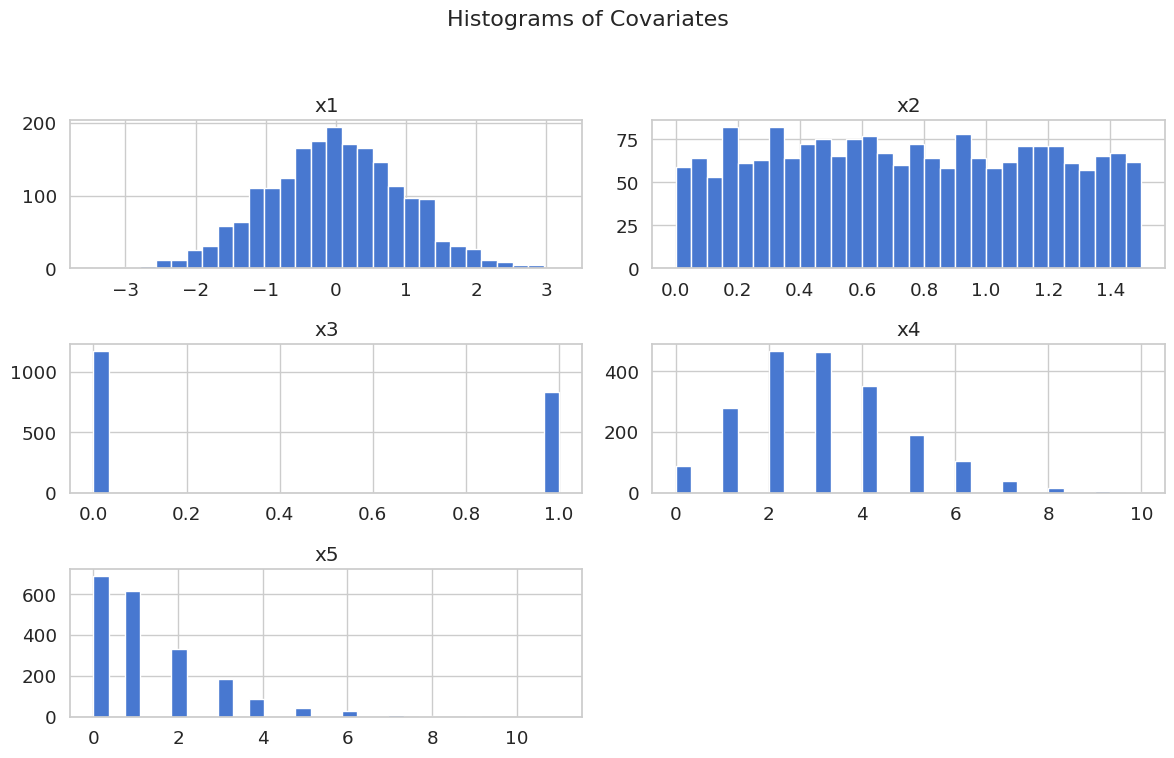

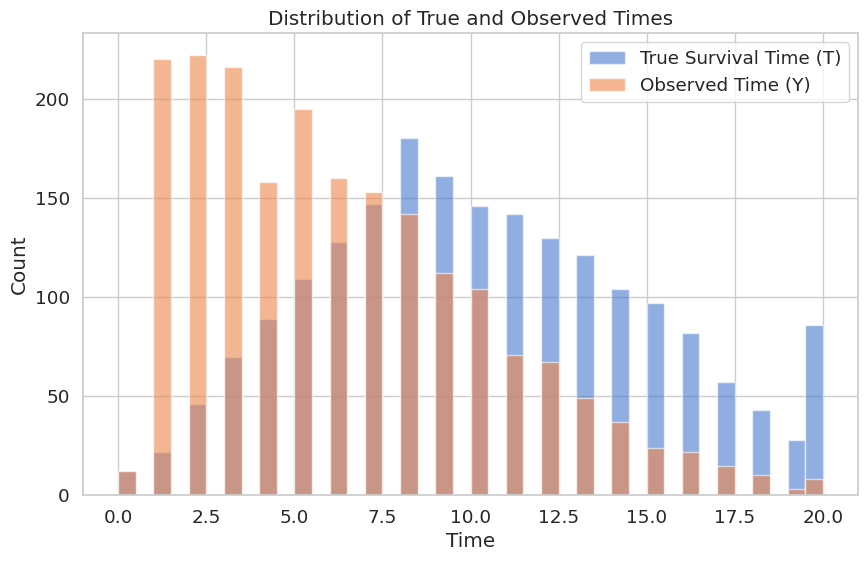

Skipping Kaplan-Meier plot: lifelines not available.


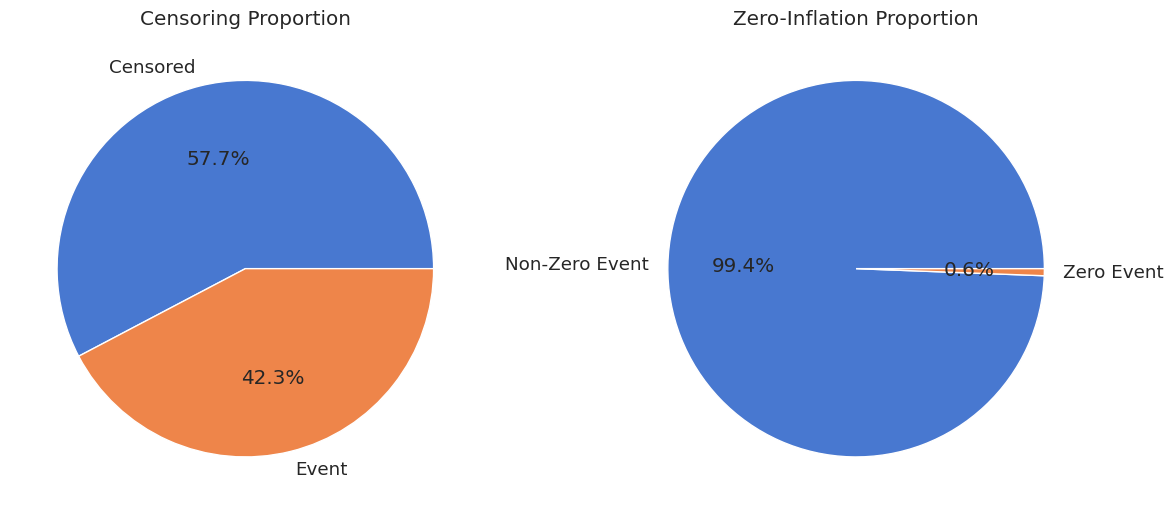

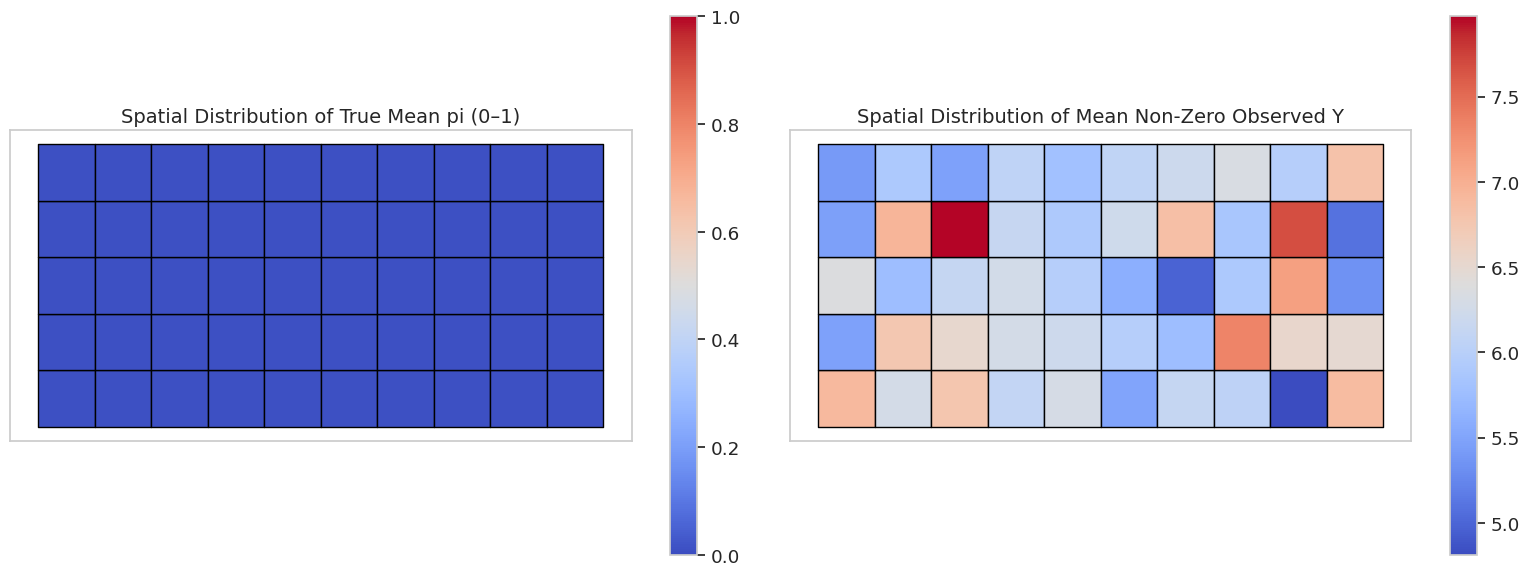

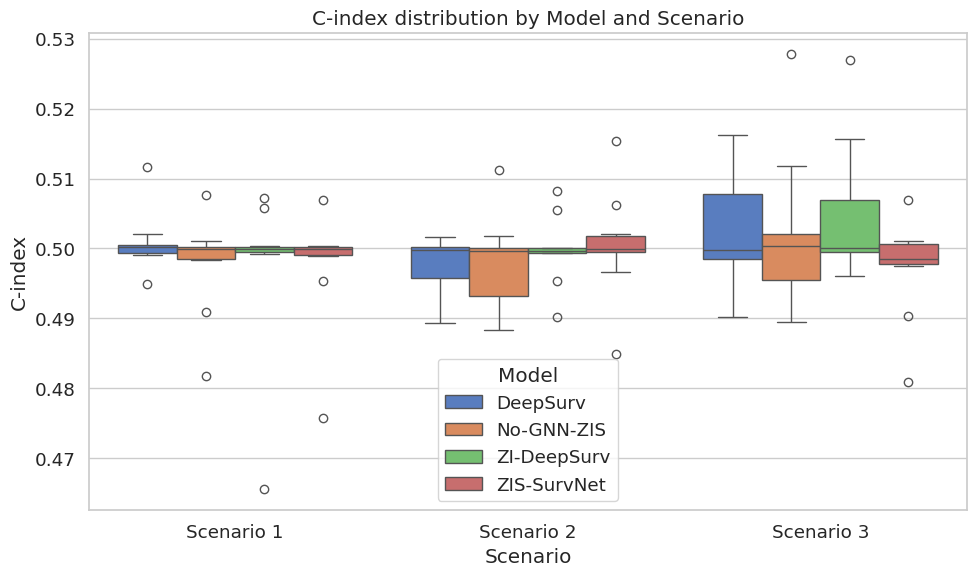

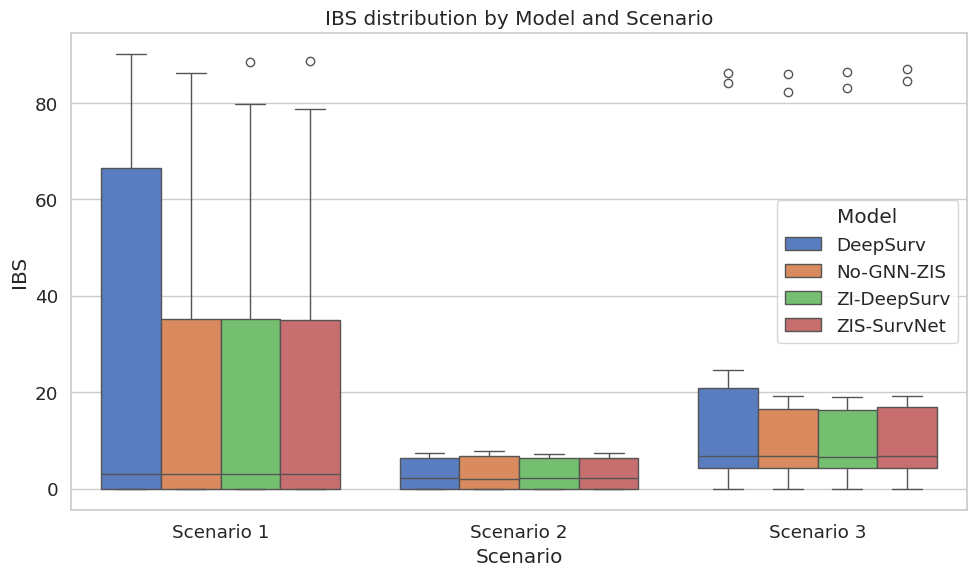

In [3]:
!pip install numpy scipy pandas matplotlib scikit-learn networkx
!pip install torch torchvision torchaudio  # (برای PyTorch - بسته به سیستم، ممکن است نیاز به تنظیم CUDA داشته باشید؛ برای CPU: pip install torch)
!pip install torch_geometric  # برای GCN در PyTorch Geometric
!pip install numpy pandas matplotlib seaborn tqdm lifelines
!pip install torch torchvision torchaudio torch-geometric
!pip install scikit-learn scipy
!pip install networkx
import os
import sys
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
import pickle
from scipy import stats
import networkx as nx

# Survival libraries (optional)
try:
    from lifelines.utils import concordance_index as lifelines_cindex
    from lifelines import KaplanMeierFitter
    from lifelines.metrics import integrated_brier_score
    HAS_LIFELINES = True
except ImportError:
    HAS_LIFELINES = False

# PyTorch Geometric (optional)
try:
    from torch_geometric.nn import GCNConv
    HAS_PYG = True
except ImportError:
    HAS_PYG = False

# GeoPandas and NetworkX for maps (optional)
try:
    import geopandas as gpd
    from shapely.geometry import Polygon
    HAS_GEOPANDAS = True
except ImportError:
    HAS_GEOPANDAS = False

sns.set(style="whitegrid", font_scale=1.2, palette="muted")
np.random.seed(42)

# Helper functions and Model classes (اضافه شده)

def manual_c_index(y_true, event_observed, risk_score):
    """Manual calculation of concordance index for survival data."""
    # Ensure inputs are numpy arrays
    y_true = np.asarray(y_true)
    event_observed = np.asarray(event_observed)
    risk_score = np.asarray(risk_score)

    # Filter out censored observations where the event time is less than or equal to others
    # We only consider pairs where the individual with the earlier time had an event
    comparable_pairs = 0
    concordant_pairs = 0

    for i in range(len(y_true)):
        for j in range(len(y_true)):
            # Skip if same individual
            if i == j:
                continue

            # Check if pair (i, j) is comparable
            # i is comparable to j if y_true[i] < y_true[j] and event_observed[i] == 1
            # or if y_true[i] == y_true[j] and event_observed[i] == 1 and event_observed[j] == 1
            if (y_true[i] < y_true[j] and event_observed[i] == 1) or \
               (y_true[i] == y_true[j] and event_observed[i] == 1 and event_observed[j] == 1):

                comparable_pairs += 1

                # Check if concordant
                # For survival data, lower risk score is better (higher survival probability)
                # So concordant if risk_score[i] < risk_score[j]
                if risk_score[i] < risk_score[j]:
                    concordant_pairs += 1
                elif risk_score[i] == risk_score[j]:
                    # Handle ties in risk scores - count as 0.5
                    concordant_pairs += 0.5

    if comparable_pairs == 0:
        return 0.5  # By convention, C-index is 0.5 if no comparable pairs

    return concordant_pairs / comparable_pairs

def simple_ibs_discrete(y_true, event_observed, q_pred, beta_pred, times):
    """
    Simple implementation of Integrated Brier Score for discrete time.
    Assumes y_true is observed time, event_observed is delta (1 if event, 0 if censored).
    q_pred and beta_pred are parameters from the model.
    times are the time points for evaluation.
    """
    y_true = np.asarray(y_true)
    event_observed = np.asarray(event_observed)
    q_pred = np.asarray(q_pred)
    beta_pred = np.asarray(beta_pred)
    times = np.asarray(times) # Ensure times is a numpy array

    n = len(y_true)
    total_brier_score = 0
    num_times = len(times)

    for t in times:
        # Kaplan-Meier estimate for censoring
        km_censoring = KaplanMeierFitter() if HAS_LIFELINES else None
        if HAS_LIFELINES:
            km_censoring.fit(y_true, event_observed=1 - event_observed) # Fit on censoring events
            prob_censored_after_t = km_censoring.predict(t) if t in km_censoring.survival_function_.index else (km_censoring.survival_function_.iloc[-1] if t > km_censoring.survival_function_.index[-1] else 1.0)
        else:
             # Simple censoring probability estimate (less accurate)
             prob_censored_after_t = np.mean(y_true > t)

        if prob_censored_after_t == 0:
             # Avoid division by zero, skip this time point if no one is at risk
             continue

        # Calculate Brier Score at time t
        brier_score_t = 0
        num_at_risk = 0

        for i in range(n):
            # Only consider individuals who are at risk at time t (observed time >= t)
            if y_true[i] >= t:
                num_at_risk += 1
                # Predicted survival probability at time t
                S_hat_t = q_pred[i] ** (t ** beta_pred[i])

                # Brier score contribution for individual i at time t
                if y_true[i] > t:
                    # Individual survived past time t
                    brier_score_i = (0 - S_hat_t)**2
                elif y_true[i] <= t and event_observed[i] == 1:
                    # Individual had an event at or before time t
                    brier_score_i = (1 - S_hat_t)**2
                else:
                    # Individual is censored before or at time t, not included in the sum
                    continue

                # Inverse Probability of Censoring Weighting (IPCW)
                # Weight by the probability of not being censored before or at time t
                weight_i = 1.0 / prob_censored_after_t # Simplified: using overall KM for censoring

                brier_score_t += weight_i * brier_score_i

        if num_at_risk > 0:
            brier_score_t /= num_at_risk
            total_brier_score += brier_score_t

    if num_times == 0:
        return 0.0, [] # Return 0 IBS if no times are provided
    # Average over the time points
    integrated_brier_score_val = total_brier_score / num_times

    # Note: This is a simplified IBS. A proper implementation requires
    # a more robust IPCW calculation and handling of continuous time.
    return integrated_brier_score_val, [] # Returning empty list for times for simplicity


def surv_nll_loss(q, beta, y, delta):
    """
    Negative Log-Likelihood loss for standard discrete survival model
    with Weibull-like survival function S(t) = q^t^beta.
    y: observed time (discrete)
    delta: event indicator (1 if event, 0 if censored)
    """
    y = y.long() # Ensure y is long for indexing
    q = torch.clamp(q, 1e-6, 1 - 1e-6) # Clamp q to avoid numerical issues
    beta = torch.relu(beta) + 1e-6 # Ensure beta is positive

    # Survival function S(t) = q^(t^beta)
    # S(t-1) = q^((t-1)^beta)
    # P(T=t) = S(t-1) - S(t) = q^((t-1)^beta) - q^(t^beta)

    # Handle y=0 case separately if needed, but in this model T >= 1
    # For y=1: P(T=1) = S(0) - S(1) = q^(0^beta) - q^(1^beta) = 1 - q^1
    # For y>1: P(T=y) = S(y-1) - S(y) = q^((y-1)^beta) - q^(y^beta)

    # Probability of event at time y: P(T=y) if delta=1
    # Probability of surviving beyond time y: S(y) if delta=0

    # Calculate S(y) and S(y-1)
    S_y = q ** (y.float() ** beta)
    S_y_minus_1 = torch.ones_like(y).float() # S(0) = 1
    mask_y_gt_1 = (y > 1)
    S_y_minus_1[mask_y_gt_1] = q[mask_y_gt_1] ** ((y[mask_y_gt_1].float() - 1) ** beta[mask_y_gt_1])

    # Probability density at time y: P(T=y)
    p_y = S_y_minus_1 - S_y
    p_y = torch.clamp(p_y, 1e-9, 1 - 1e-9) # Clamp probability

    # Loss for observed events (delta=1): -log(P(T=y))
    event_loss = -torch.log(p_y[delta == 1])

    # Loss for censored observations (delta=0): -log(S(y))
    censoring_loss = -torch.log(S_y[delta == 0])

    # Total NLL
    total_loss = torch.sum(event_loss) + torch.sum(censoring_loss)

    return total_loss / len(y) # Return mean NLL


def zis_nll_loss(pi, q, beta, y, delta):
    """
    Negative Log-Likelihood loss for Zero-Inflated Survival model.
    pi: probability of being in the zero-inflation component
    q: base survival parameter for the non-zero component
    beta: shape parameter for the non-zero component survival
    y: observed time (discrete)
    delta: event indicator (1 if event, 0 if censored)
    """
    y = y.long() # Ensure y is long for indexing
    pi = torch.clamp(pi, 1e-6, 1 - 1e-6) # Clamp pi
    q = torch.clamp(q, 1e-6, 1 - 1e-6) # Clamp q
    beta = torch.relu(beta) + 1e-6 # Ensure beta is positive

    # S_nz(t) = q^(t^beta)  (Survival function for non-zero component)
    S_nz_y = q ** (y.float() ** beta)
    S_nz_y_minus_1 = torch.ones_like(y).float() # S_nz(0) = 1
    mask_y_gt_1 = (y > 1)
    S_nz_y_minus_1[mask_y_gt_1] = q[mask_y_gt_1] ** ((y[mask_y_gt_1].float() - 1) ** beta[mask_y_gt_1])

    # Probability density for non-zero component: p_nz(y) = S_nz(y-1) - S_nz(y)
    p_nz_y = S_nz_y_minus_1 - S_nz_y
    p_nz_y = torch.clamp(p_nz_y, 1e-9, 1 - 1e-9) # Clamp probability

    # Overall probability of event at time y:
    # If y_i = 0 (implies delta_i = 1 in this simulation setup)
    # L_i = P(Y_i=0, delta_i=1) = pi_i

    # If y_i > 0 and delta_i = 1 (event at time y_i):
    # L_i = P(Y_i=y_i, delta_i=1) = P(T_i=y_i) = (1-pi_i) * P(T_nz_i=y_i)
    # P(T_nz_i=y_i) = S_nz_i(y_i-1) - S_nz_i(y_i)
    # L_i = (1-pi_i) * (S_nz_i(y_i-1) - S_nz_i(y_i))

    # If y_i > 0 and delta_i = 0 (censored at time y_i):
    # L_i = P(Y_i > y_i, delta_i=0) = P(T_i > y_i) = (1-pi_i) * P(T_nz_i > y_i)
    # P(T_nz_i > y_i) = S_nz_i(y_i)
    # L_i = (1-pi_i) * S_nz_i(y_i)

    # Combine into negative log-likelihood:
    loss = 0.0
    epsilon = 1e-9 # for numerical stability

    # Case 1: y_i = 0 (implies delta_i = 1 in this simulation setup)
    mask_y_is_zero = (y == 0)
    if torch.any(mask_y_is_zero):
        loss += -torch.sum(torch.log(pi[mask_y_is_zero] + epsilon))

    # Case 2: y_i > 0 and delta_i = 1 (event at time y_i > 0)
    mask_event_nonzero = (y > 0) & (delta == 1)
    if torch.any(mask_event_nonzero):
        prob_event_at_y = (1 - pi[mask_event_nonzero]) * (S_nz_y_minus_1[mask_event_nonzero] - S_nz_y[mask_event_nonzero])
        loss += -torch.sum(torch.log(prob_event_at_y + epsilon))

    # Case 3: y_i > 0 and delta_i = 0 (censored at time y_i > 0)
    mask_censored_nonzero = (y > 0) & (delta == 0)
    if torch.any(mask_censored_nonzero):
        prob_survive_past_y = (1 - pi[mask_censored_nonzero]) * S_nz_y[mask_censored_nonzero]
        loss += -torch.sum(torch.log(prob_survive_past_y + epsilon))

    return loss / len(y) # Return mean NLL


class DeepSurvLike(nn.Module):
    """
    A basic Feedforward Neural Network for survival analysis,
    predicting parameters for a Weibull-like discrete survival model.
    Similar structure to DeepSurv but adapted for discrete time.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(DeepSurvLike, self).__init__()
        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) # Added dropout
            current_dim = h_dim

        self.feature_extractor = nn.Sequential(*layers)

        # Output layer for q (base survival rate) and beta (shape parameter)
        # q should be between 0 and 1. Use sigmoid or clamp after linear.
        # beta should be positive. Use softplus or relu + epsilon.
        self.q_layer = nn.Linear(current_dim, 1)
        self.beta_layer = nn.Linear(current_dim, 1)

    def forward(self, x):
        features = self.feature_extractor(x)
        q_logit = self.q_layer(features)
        beta_raw = self.beta_layer(features)

        q = torch.sigmoid(q_logit).squeeze(-1) # Sigmoid to ensure q is between 0 and 1
        beta = F.softplus(beta_raw).squeeze(-1) + 1e-6 # Softplus to ensure beta is positive

        return q, beta


class ZIDeepSurv(nn.Module):
    """
    Zero-Inflated DeepSurv-like model without spatial components.
    Predicts pi (zero-inflation prob), q, and beta based only on covariates X.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(ZIDeepSurv, self).__init__()
        layers = []
        current_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) # Added dropout
            current_dim = h_dim

        self.feature_extractor = nn.Sequential(*layers)

        # Output layers for pi, q, and beta
        self.pi_layer = nn.Linear(current_dim, 1)
        self.q_layer = nn.Linear(current_dim, 1)
        self.beta_layer = nn.Linear(current_dim, 1)

    def forward(self, x):
        features = self.feature_extractor(x)

        pi_logit = self.pi_layer(features)
        q_logit = self.q_layer(features)
        beta_raw = self.beta_layer(features)

        pi = torch.sigmoid(pi_logit).squeeze(-1)
        q = torch.sigmoid(q_logit).squeeze(-1)
        beta = F.softplus(beta_raw).squeeze(-1) + 1e-6

        return pi, q, beta


class NoGNN_ZIS(nn.Module):
    """
    Zero-Inflated Survival model using region-level features (mean covariates)
    instead of a GNN for spatial information.
    """
    def __init__(self, input_dim, region_feat_dim, hidden_dims=[64, 32]):
        super(NoGNN_ZIS, self).__init__()
        # Combine individual features (X) and region features
        combined_dim = input_dim + region_feat_dim
        layers = []
        current_dim = combined_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) # Added dropout
            current_dim = h_dim

        self.feature_extractor = nn.Sequential(*layers)

        self.pi_layer = nn.Linear(current_dim, 1)
        self.q_layer = nn.Linear(current_dim, 1)
        self.beta_layer = nn.Linear(current_dim, 1)

    def forward(self, x, region_features_aggregated):
        # Concatenate individual features with aggregated region features
        combined_features = torch.cat([x, region_features_aggregated], dim=-1)
        features = self.feature_extractor(combined_features)

        pi_logit = self.pi_layer(features)
        q_logit = self.q_layer(features)
        beta_raw = self.beta_layer(features)

        pi = torch.sigmoid(pi_logit).squeeze(-1)
        q = torch.sigmoid(q_logit).squeeze(-1)
        beta = F.softplus(beta_raw).squeeze(-1) + 1e-6

        return pi, q, beta


class ZISSurvNet_GNN(nn.Module):
    """
    Zero-Inflated Survival Network using a GCN layer to incorporate spatial information.
    Individual features (X) are combined with region-level features learned by GCN.
    """
    def __init__(self, input_dim, num_regions, gcn_hidden_dim=16, hidden_dims=[64, 32]):
        super(ZISSurvNet_GNN, self).__init__()
        if not HAS_PYG:
            raise ImportError("torch_geometric is required for ZISSurvNet_GNN")

        self.num_regions = num_regions
        self.gcn_hidden_dim = gcn_hidden_dim

        # Initial linear layer to project individual features before aggregation
        self.individual_proj = nn.Linear(input_dim, gcn_hidden_dim)

        # GCN layer operating on the graph of regions
        # Input to GCN will be aggregated features per region
        self.gcn1 = GCNConv(gcn_hidden_dim, gcn_hidden_dim)
        # self.gcn2 = GCNConv(gcn_hidden_dim, gcn_hidden_dim) # Optional second GCN layer

        # Combine individual features (X) and GCN-processed region features
        # Individual features (input_dim) + GCN output features (gcn_hidden_dim)
        combined_dim = input_dim + gcn_hidden_dim
        layers = []
        current_dim = combined_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2)) # Added dropout
            current_dim = h_dim

        self.feature_extractor = nn.Sequential(*layers)

        self.pi_layer = nn.Linear(current_dim, 1)
        self.q_layer = nn.Linear(current_dim, 1)
        self.beta_layer = nn.Linear(current_dim, 1)

    def forward(self, x, region_ids, edge_index):
        # Project individual features and aggregate to region level
        individual_features_proj = self.individual_proj(x)

        # Aggregate projected individual features by region (e.g., mean aggregation)
        # Create a tensor to hold aggregated region features
        region_features_agg = torch.zeros(self.num_regions, self.gcn_hidden_dim, device=x.device)

        # Use torch_scatter or manual aggregation
        # Manual aggregation:
        for r in range(self.num_regions):
            indices = (region_ids == r).nonzero(as_tuple=True)[0]
            if indices.numel() > 0:
                region_features_agg[r] = individual_features_proj[indices].mean(dim=0)


        # Pass aggregated region features through GCN
        # GCNConv requires edge_index and node features (region_features_agg)
        # Optional: use edge_weight if available and meaningful
        gcn_out = F.relu(self.gcn1(region_features_agg, edge_index))
        # gcn_out = F.relu(self.gcn2(gcn_out, edge_index)) # Optional second GCN layer


        # Map GCN output back to individuals based on their region_id
        gcn_features_per_individual = gcn_out[region_ids]

        # Concatenate original individual features with GCN features
        combined_features = torch.cat([x, gcn_features_per_individual], dim=-1)

        # Pass combined features through the final feature extractor
        features = self.feature_extractor(combined_features)

        pi_logit = self.pi_layer(features)
        q_logit = self.q_layer(features)
        beta_raw = self.beta_layer(features)

        pi = torch.sigmoid(pi_logit).squeeze(-1)
        q = torch.sigmoid(q_logit).squeeze(-1)
        beta = F.softplus(beta_raw).squeeze(-1) + 1e-6

        return pi, q, beta


class ZISSimulation:
    def __init__(self, num_simulations=100, epochs=100, lr=1e-3, device='cpu', out_folder="zis_sim_results", h=1.0, epsilon=1e-5):
        self.num_simulations = num_simulations
        self.epochs = epochs
        self.lr = lr
        self.device = device
        self.out_folder = out_folder
        self.h = h
        self.epsilon = epsilon
        self.rx, self.ry = 10, 5
        self.num_regions = self.rx * self.ry
        self.region_coords = [(i,j) for i in range(self.rx) for j in range(self.ry)]
        self.adj_matrix = self._build_lattice_adj()
        self.scenarios = self._define_scenarios()
        self.results_accumulator = {s: {
            'DeepSurv': [],
            'No-GNN-ZIS': [],
            'ZI-DeepSurv': [],
            'ZIS-SurvNet': []
        } for s in self.scenarios}  # BICAR-ZIDW حذف شد
        self.final_df = None
        self.last_sim_data = None

    def _build_lattice_adj(self):
        G = nx.grid_2d_graph(self.rx, self.ry)
        R = self.num_regions
        adj = np.zeros((R, R), dtype=float)
        for idx1, coord1 in enumerate(self.region_coords):
            for idx2, coord2 in enumerate(self.region_coords):
                if idx1 == idx2:
                    continue
                d = nx.shortest_path_length(G, coord1, coord2)
                if d == 1:
                    adj[idx1, idx2] = 1
                else:
                    adj[idx1, idx2] = np.exp(-d / self.h)
        return adj

    def _define_scenarios(self):
        sigma1_moderate = np.array([[1., 0.612], [0.612, 1.5]])
        sigma1_strong = np.array([[2., 1.959], [1.959, 3.]])
        return {
            1: {'desc': 'Moderate zero inflation, rho=0.5', 'Sigma': sigma1_moderate, 'GAMMA0': -1.5, 'ALPHA0': 0.5, 'BETA_SURV': 1.2, 'CENSOR_P': 0.1, 'clip_q': (1e-4, 0.99), 'clip_pi': (0.01, 0.99), 'max_time': 20},
            2: {'desc': 'High zero inflation', 'Sigma': sigma1_moderate, 'GAMMA0': -0.4, 'ALPHA0': 0.5, 'BETA_SURV': 1.2, 'CENSOR_P': 0.1, 'clip_q': (1e-4, 0.99), 'clip_pi': (0.01, 0.99), 'max_time': 20},
            3: {'desc': 'Strong spatial dependence', 'Sigma': sigma1_strong, 'GAMMA0': -1.5, 'ALPHA0': 0.5, 'BETA_SURV': 1.2, 'CENSOR_P': 0.1, 'clip_q': (1e-4, 0.99), 'clip_pi': (0.01, 0.99), 'max_time': 20}
        }

    def _generate_dataset(self, seed, **kwargs):
        # بدون تغییر (مشابه کد اصلی)
        np.random.seed(seed)
        num_individuals = kwargs.get('num_individuals', 2000)
        X_dim = 5
        region_ids = np.random.choice(self.num_regions, num_individuals)
        X = np.zeros((num_individuals, X_dim))
        X[:, 0] = np.random.normal(0, 1, num_individuals)
        X[:, 1] = np.random.uniform(0, 1.5, num_individuals)
        X[:, 2] = np.random.binomial(1, 0.4, num_individuals)
        X[:, 3] = np.random.poisson(3, num_individuals)
        X[:, 4] = np.random.negative_binomial(2, 0.6, num_individuals)

        R = self.num_regions
        adj = self.adj_matrix
        D = np.diag(adj.sum(axis=1))
        Q = D - adj + self.epsilon * np.eye(R)
        inv_Q = np.linalg.inv(Q)
        Sigma = kwargs['Sigma']
        cov_matrix = np.kron(inv_Q, Sigma)
        phi_flat = np.random.multivariate_normal(mean=np.zeros(R*2), cov=cov_matrix)
        phi = phi_flat.reshape((R, 2))

        # Ensure ALPHA and GAMMA are provided in kwargs
        ALPHA = kwargs.get('ALPHA', np.zeros(X_dim))
        GAMMA = kwargs.get('GAMMA', np.zeros(X_dim))


        lin_q = kwargs['ALPHA0'] + X.dot(ALPHA) + phi[region_ids, 1]
        q = np.exp(-np.exp(lin_q))
        q = np.clip(q, kwargs['clip_q'][0], kwargs['clip_q'][1])

        lin_pi = kwargs['GAMMA0'] + X.dot(GAMMA) + phi[region_ids, 0]
        pi = 1 / (1 + np.exp(-lin_pi))
        pi = np.clip(pi, kwargs['clip_pi'][0], kwargs['clip_pi'][1])

        T = np.zeros(num_individuals, dtype=int)
        Y = np.zeros(num_individuals, dtype=int)
        for i in range(num_individuals):
            if np.random.rand() < pi[i]:
                T[i] = 0
                Y[i] = 0
            else:
                T_i = 1
                while True:
                    S_Ti = q[i] ** (T_i ** kwargs['BETA_SURV'])
                    if np.random.rand() > S_Ti or T_i >= kwargs['max_time']:
                        T[i] = T_i
                        Y[i] = T_i
                        break
                    T_i += 1

        C = np.random.geometric(kwargs['CENSOR_P'], num_individuals)
        delta = (Y <= C).astype(int)
        Y = np.minimum(Y, C)

        df = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(X_dim)])
        df['region_id'] = region_ids
        df['phi1'] = phi[region_ids, 0]
        df['phi2'] = phi[region_ids, 1]
        df['pi_true'] = pi
        df['q_true'] = q
        df['T'] = T
        df['Y'] = Y
        df['delta'] = delta
        df['is_zero'] = (df['Y'] == 0).astype(int)

        self.last_sim_data = df

        summary = {
            'prop_zero': df['is_zero'].mean(),
            'prop_censored': (1 - df['delta']).mean()
        }
        return df, X, region_ids, summary

    def _train_and_evaluate(self, df, X, region_ids, adj_matrix, **kwargs):
        metrics = {}
        X_t = torch.tensor(X, dtype=torch.float32).to(self.device)
        region_ids_t = torch.tensor(region_ids, dtype=torch.long).to(self.device)
        Y_t = torch.tensor(df['Y'].values, dtype=torch.float32).to(self.device)
        delta_t = torch.tensor(df['delta'].values, dtype=torch.float32).to(self.device)

        edge_index = None
        if HAS_PYG:
            rows, cols = np.where(adj_matrix > 0)
            edge_index = torch.tensor(np.vstack([rows, cols]), dtype=torch.long).to(self.device)
            # edge_weight = torch.tensor(adj_matrix[rows, cols], dtype=torch.float32).to(self.device) # edge_weight not used in GCNConv here
        # else: edge_weight = None # edge_weight not used

        R = adj_matrix.shape[0]
        region_features = torch.zeros(R, X.shape[1], dtype=torch.float32).to(self.device)
        for r in range(R):
            indices = (region_ids_t == r).nonzero(as_tuple=True)[0]
            if indices.numel() > 0:
                region_features[r] = X_t[indices].mean(dim=0)

        models_to_run = {
            'DeepSurv': DeepSurvLike(input_dim=X.shape[1]).to(self.device),
            'No-GNN-ZIS': NoGNN_ZIS(input_dim=X.shape[1], region_feat_dim=X.shape[1]).to(self.device),
            'ZI-DeepSurv': ZIDeepSurv(input_dim=X.shape[1]).to(self.device),
            'ZIS-SurvNet': ZISSurvNet_GNN(input_dim=X.shape[1], num_regions=R).to(self.device)
        }

        for name, model in models_to_run.items():
            try:
                optimizer = Adam(model.parameters(), lr=self.lr)
                for epoch in range(self.epochs): # Corrected loop variable name
                    model.train()
                    optimizer.zero_grad()
                    if name == 'ZIS-SurvNet':
                        # Check if edge_index is None and HAS_PYG is False
                        if not HAS_PYG:
                             print(f"Skipping training for {name}: torch_geometric not available.")
                             continue
                        pi, q, beta = model(X_t, region_ids_t, edge_index=edge_index)
                        loss = zis_nll_loss(pi, q, beta, Y_t, delta_t)
                    elif name == 'No-GNN-ZIS':
                        pi, q, beta = model(X_t, region_features[region_ids_t])
                        loss = zis_nll_loss(pi, q, beta, Y_t, delta_t)
                    elif name == 'ZI-DeepSurv':
                        pi, q, beta = model(X_t)
                        loss = zis_nll_loss(pi, q, beta, Y_t, delta_t)
                    else: # DeepSurv
                        q, beta = model(X_t)
                        loss = surv_nll_loss(q, beta, Y_t, delta_t)

                    # Check for NaN loss
                    if torch.isnan(loss):
                         print(f"NaN loss encountered for {name} in epoch {epoch}. Skipping.")
                         break # Exit epoch loop for this model

                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    if name in ['ZIS-SurvNet', 'No-GNN-ZIS', 'ZI-DeepSurv']:
                        if name == 'ZIS-SurvNet':
                            if not HAS_PYG:
                                 print(f"Skipping evaluation for {name}: torch_geometric not available.")
                                 continue # Skip evaluation if GNN was skipped
                            pi_pred_t, q_pred_t, beta_t = model(X_t, region_ids_t, edge_index=edge_index)
                        elif name == 'No-GNN-ZIS':
                            pi_pred_t, q_pred_t, beta_t = model(X_t, region_features[region_ids_t])
                        else: # ZI-DeepSurv
                            pi_pred_t, q_pred_t, beta_t = model(X_t)

                        pi_pred = pi_pred_t.cpu().numpy()
                        q_pred = q_pred_t.cpu().numpy()
                        # Ensure beta_t is converted to a numpy array correctly
                        beta_val = beta_t.cpu().numpy()


                        # Metric calculations for ZIS models
                        # Ensure beta_val is broadcastable if it's a single value
                        if beta_val.ndim == 0: # Check if it's a scalar
                             beta_val = np.full_like(q_pred, beta_val) # Broadcast scalar to shape of q_pred
                        elif beta_val.shape != q_pred.shape:
                             # If beta is per-individual but shapes don't match (shouldn't happen with squeeze(-1)),
                             # you might need a different broadcasting strategy or an error
                             print(f"Warning: beta_val shape {beta_val.shape} does not match q_pred shape {q_pred.shape} for {name}.")
                             # Attempt to broadcast if possible, or handle error
                             try:
                                 beta_val = np.broadcast_to(beta_val, q_pred.shape)
                             except ValueError:
                                 print(f"Error broadcasting beta_val for {name}. Skipping metrics.")
                                 metrics[name] = {}
                                 continue


                        p_zero = pi_pred + (1 - pi_pred) * (1 - q_pred ** beta_val) # P(Y=0)
                        metrics[name] = {
                            'NLL': zis_nll_loss(pi_pred_t, q_pred_t, beta_t, Y_t, delta_t).item(),
                            'AUC': roc_auc_score(df['is_zero'], -p_zero), # AUC for predicting zero (event)
                            'MAE_pi': mean_absolute_error(df['pi_true'], pi_pred),
                            'Bias_pi': np.mean(pi_pred - df['pi_true']),
                            'MSE_pi': mean_squared_error(df['pi_true'], pi_pred),
                            'Brier_pi': mean_squared_error(df['is_zero'], p_zero), # Brier score for zero prediction
                            'MSE_q': mean_squared_error(df['q_true'], q_pred),
                            'Bias_q': np.mean(q_pred - df['q_true']),
                            'Bias_beta': np.mean(beta_val - kwargs['BETA_SURV']) # Calculate mean bias for beta
                        }
                        # MSE_total is not standard, maybe remove or clarify
                        # metrics[name]['MSE_total'] = metrics[name]['Brier_pi'] + metrics[name]['MSE_q']

                    else: # DeepSurv
                        q_pred_t, beta_t = model(X_t)
                        q_pred = q_pred_t.cpu().numpy()
                        # Ensure beta_t is converted to a numpy array correctly
                        beta_val = beta_t.cpu().numpy()
                        if beta_val.ndim == 0: # Check if it's a scalar
                             beta_val = np.full_like(q_pred, beta_val) # Broadcast scalar to shape of q_pred
                        elif beta_val.shape != q_pred.shape:
                             print(f"Warning: beta_val shape {beta_val.shape} does not match q_pred shape {q_pred.shape} for {name}.")
                             try:
                                 beta_val = np.broadcast_to(beta_val, q_pred.shape)
                             except ValueError:
                                 print(f"Error broadcasting beta_val for {name}. Skipping metrics.")
                                 metrics[name] = {}
                                 continue


                        p_zero = 1 - q_pred ** beta_val # DeepSurv predicts P(Y=0) implicitly

                        metrics[name] = {
                            'NLL': surv_nll_loss(q_pred_t, beta_t, Y_t, delta_t).item(),
                            'AUC': roc_auc_score(df['is_zero'], -p_zero), # AUC for predicting zero (event)
                            'Brier_pi': mean_squared_error(df['is_zero'], p_zero), # Brier score for zero prediction
                            'MSE_q': mean_squared_error(df['q_true'], q_pred),
                            'Bias_q': np.mean(q_pred - df['q_true']),
                            'Bias_beta': np.mean(beta_val - kwargs['BETA_SURV']) # Calculate mean bias for beta
                        }
                        # MSE_total not standard
                        # metrics[name]['MSE_total'] = metrics[name]['Brier_pi'] + metrics[name]['MSE_q']

                    # Survival metrics (C-index, IBS)
                    # For ZIS models, risk score could be related to expected time or P(Y=0)
                    # A common approach is to use -log(S(y)) or similar from the non-zero part, or P(Y>0)
                    # Let's use P(Y>0) = 1 - P(Y=0) as a risk score (higher P(Y>0) means lower risk of zero, higher survival potential)
                    # Or use the non-zero survival function S_nz(t)
                    # Let's use the risk score from the non-zero component: -log(-log(np.clip(q_pred, 1e-6, 1 - 1e-6)))
                    # Use the negative expected time in the non-zero component as risk score
                    # Calculate expected time for non-zero component
                    max_sum_t_risk = kwargs['max_time'] + 20
                    t_sum_risk = np.arange(1, max_sum_t_risk + 1)
                    q_pred_broadcast_risk = q_pred[:, np.newaxis]
                    beta_val_broadcast_risk = beta_val[:, np.newaxis]
                    S_nz_sum_risk = q_pred_broadcast_risk ** (t_sum_risk[np.newaxis, :] ** beta_val_broadcast_risk)
                    E_T_nz_risk = np.sum(S_nz_sum_risk, axis=1)

                    risk_scores = -E_T_nz_risk # Use negative expected time as risk score


                    cidx = lifelines_cindex(df['Y'].values, -risk_scores, df['delta'].astype(bool)) if HAS_LIFELINES else manual_c_index(df['Y'].values, df['delta'].values, risk_scores)
                    metrics[name]['C-index'] = cidx

                    # IBS needs predicted survival probabilities S(t)
                    # For ZIS: S(t) = (1-pi) * S_nz(t) + pi * I(t=0)
                    # Since we are evaluating at times t >= 1, S(t) = (1-pi) * S_nz(t) for t>=1
                    times = np.arange(1, kwargs['max_time'] + 1) # Evaluate up to max_time
                    if name in ['ZIS-SurvNet', 'No-GNN-ZIS', 'ZI-DeepSurv']:
                        # S(t) = (1-pi) * q^t^beta for t > 0
                         # Ensure pi_pred and beta_val are correctly shaped for broadcasting
                        pi_pred_broadcast = pi_pred[:, np.newaxis]
                        q_pred_broadcast = q_pred[:, np.newaxis]
                        beta_val_broadcast = beta_val[:, np.newaxis] # Ensure beta is also broadcastable

                        surv_probs = (1 - pi_pred_broadcast) * (q_pred_broadcast ** (times[np.newaxis, :] ** beta_val_broadcast))

                    else: # DeepSurv
                        # S(t) = q^t^beta for t > 0
                        q_pred_broadcast = q_pred[:, np.newaxis]
                        beta_val_broadcast = beta_val[:, np.newaxis]
                        surv_probs = q_pred_broadcast ** (times[np.newaxis, :] ** beta_val_broadcast)


                    # Ensure surv_probs is numpy array for lifelines_cindex and simple_ibs_discrete
                    surv_probs_np = surv_probs # surv_probs should already be numpy from the calculations above

                    ibs_val = integrated_brier_score(df['Y'].values, df['delta'].astype(bool), surv_probs_np, times) if HAS_LIFELINES else simple_ibs_discrete(df['Y'].values, df['delta'].values, q_pred, beta_val, times=times)[0]

                    metrics[name]['IBS'] = ibs_val

                    # MAE_exp calculation (Mean Absolute Error of Expected Non-Zero Time)
                    # Expected time for non-zero component E[T_nz] = sum_{t=1}^inf S_nz(t)
                    mask = (df['Y'] > 0) & (df['delta'] == 1) # Only consider observed non-zero event times for this metric
                    if mask.sum() > 0:
                        q_pred_m = q_pred[mask]
                        beta_m = beta_val[mask] # Get beta values for the masked individuals

                        # Estimate E[T_nz] by summing S_nz(t) up to a large time
                        max_sum_t = kwargs['max_time'] + 20 # Sum beyond max_time to approximate infinity
                        t_sum = np.arange(1, max_sum_t + 1) # Sum from t=1
                        # S_nz(t) = q^t^beta
                        # Ensure q_pred_m and beta_m are correctly shaped for broadcasting
                        q_pred_m_broadcast = q_pred_m[:, np.newaxis]
                        beta_m_broadcast = beta_m[:, np.newaxis]

                        S_nz_sum = q_pred_m_broadcast ** (t_sum[np.newaxis, :] ** beta_m_broadcast)
                        E_T_nz = np.sum(S_nz_sum, axis=1)

                        # The MAE_exp should compare observed non-zero event times (df['Y'][mask])
                        # with the expected time from the non-zero component (E_T_nz).
                        # This metric assesses how well the model predicts the magnitude of non-zero times.
                        mae_exp = mean_absolute_error(df['Y'][mask], E_T_nz)
                        metrics[name]['MAE_exp'] = mae_exp
                    else:
                        metrics[name]['MAE_exp'] = np.nan

            except Exception as e:
                print(f"Error training or evaluating {name}: {e}")
                metrics[name] = {}

        return metrics


    def run_full_pipeline(self):
        os.makedirs(self.out_folder, exist_ok=True)
        for s, scenario_params in self.scenarios.items():
            print(f"\n=== Running scenario {s}: {scenario_params['desc']} ===")
            for model_name in self.results_accumulator[s].keys():
                self.results_accumulator[s][model_name] = []

            for sim in tqdm(range(self.num_simulations), desc=f"Scenario {s} sims"):
                seed = sim + s * 1000
                df, X, region_ids, summary = self._generate_dataset(
                    seed=seed,
                    ALPHA=np.array([0.3, 0.2, -0.4, 0.1, 0.3]),
                    GAMMA=np.array([0.5, -0.3, 0.4, 0.2, -0.1]),
                    **scenario_params
                )
                metrics = self._train_and_evaluate(df, X, region_ids, self.adj_matrix, **scenario_params)
                for m in self.results_accumulator[s]:
                    if metrics.get(m):
                        self.results_accumulator[s][m].append(metrics[m])

        self._aggregate_results()
        self._plot_all_figures()

    def _aggregate_results(self):
        rows = []
        for s, models in self.results_accumulator.items():
            for m, metric_list in models.items():
                if not metric_list:
                    continue
                metric_names = metric_list[0].keys()
                agg = {'Scenario': f"Scenario {s}", 'Model': m}
                for metric in metric_names:
                    vals = np.array([res[metric] for res in metric_list if metric in res and not np.isnan(res[metric])])
                    if len(vals) > 1:
                        mean = np.mean(vals)
                        std = np.std(vals)
                        df = len(vals) - 1
                        # Handle case with very few data points for t-distribution
                        if df > 0:
                           t_val = stats.t.ppf(0.975, df)
                           se = std / np.sqrt(len(vals))
                           ci_low = mean - t_val * se
                           ci_high = mean + t_val * se
                           agg[metric] = f"{mean:.3f} ({ci_low:.3f}–{ci_high:.3f})"
                        else:
                           agg[metric] = f"{mean:.3f} (N/A)" # Not enough data for CI
                    elif len(vals) == 1:
                         agg[metric] = f"{vals[0]:.3f} (N/A)" # Only one data point
                    else:
                        agg[metric] = "N/A (N/A)" # No data points
                rows.append(agg)

        self.final_df = pd.DataFrame(rows)
        self.final_df.to_csv(os.path.join(self.out_folder, "aggregated_results.csv"), index=False)
        with open(os.path.join(self.out_folder, "raw_results.pkl"), "wb") as f:
            pickle.dump(self.results_accumulator, f)
        print("\n=== Final Aggregated Results ===")
        print(self.final_df.to_string(index=False))

    def _plot_all_figures(self):
        if self.last_sim_data is not None:
            df = self.last_sim_data

            # 1. Histograms of Covariates
            df[['x1','x2','x3','x4','x5']].hist(bins=30, figsize=(12,8))
            plt.suptitle("Histograms of Covariates", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
            plt.close()

            # 2. Distribution of Survival and Observed Time
            plt.figure(figsize=(10,6))
            plt.hist(df['T'], bins=40, alpha=0.6, label='True Survival Time (T)')
            plt.hist(df['Y'], bins=40, alpha=0.6, label='Observed Time (Y)')
            plt.xlabel("Time")
            plt.ylabel("Count")
            plt.legend()
            plt.title("Distribution of True and Observed Times")
            plt.show()
            plt.close()

            # 3. Kaplan-Meier Survival Curve
            if HAS_LIFELINES:
                kmf = KaplanMeierFitter()
                kmf.fit(df['Y'], event_observed=df['delta'])
                kmf.plot_survival_function()
                plt.title("Kaplan-Meier Survival Curve (Observed Data)")
                plt.show()
                plt.close()
            else:
                print("Skipping Kaplan-Meier plot: lifelines not available.")

            # 4. Censoring and Zero-Inflation Proportion
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            df['delta'].value_counts().plot.pie(ax=ax[0], autopct='%1.1f%%', labels=['Censored','Event'])
            ax[0].set_title("Censoring Proportion")
            ax[0].set_ylabel('')
            zero_counts = df['is_zero'].value_counts().sort_index()
            if 0 not in zero_counts: zero_counts[0] = 0
            if 1 not in zero_counts: zero_counts[1] = 0
            zero_counts = zero_counts.sort_index()
            ax[1].pie(zero_counts.values, labels=['Non-Zero Event','Zero Event'], autopct='%1.1f%%')
            ax[1].set_title("Zero-Inflation Proportion")
            ax[1].set_ylabel('')
            plt.tight_layout()
            plt.show()
            plt.close()

            # 5. Spatial Distribution Maps
            if HAS_GEOPANDAS:
                polygons = []
                for x, y in self.region_coords:
                    # Create polygon centered at (x, y) with side length 1
                    poly = Polygon([(x-0.5, y-0.5), (x+0.5, y-0.5), (x+0.5, y+0.5), (x-0.5, y+0.5)])
                    polygons.append(poly)

                # Calculate mean pi_true and mean non-zero Y by region
                pi_mean_by_r = df.groupby("region_id")["pi_true"].mean()
                # Calculate mean of Y for non-zero values, reindex to include all regions and fill NaN with 0
                Y_nonzero_mean_by_r = df[df["Y"] > 0].groupby("region_id")["Y"].mean().reindex(np.arange(self.num_regions)).fillna(0)

                gdf = gpd.GeoDataFrame({"region_id": np.arange(self.num_regions),
                                        "pi_mean": pi_mean_by_r.values,
                                        "Y_nonzero_mean": Y_nonzero_mean_by_r.values
                                       }, geometry=polygons, crs="EPSG:4326")

                fig, axes = plt.subplots(1, 2, figsize=(16,6))

                # Plot mean pi_true
                gdf.plot(column="pi_mean", ax=axes[0], cmap="coolwarm", legend=True, edgecolor="black", vmin=0, vmax=1)
                axes[0].set_title("Spatial Distribution of True Mean pi (0–1)", fontsize=14)
                axes[0].set_xticks([])
                axes[0].set_yticks([])

                # Plot mean non-zero Y
                # Use a colormap that handles 0 appropriately if needed, coolwarm is usually fine
                gdf.plot(column="Y_nonzero_mean", ax=axes[1], cmap="coolwarm", legend=True, edgecolor="black")
                axes[1].set_title("Spatial Distribution of Mean Non-Zero Observed Y", fontsize=14)
                axes[1].set_xticks([])
                axes[1].set_yticks([])

                plt.tight_layout()
                plt.show()
                plt.close()
            else:
                print("Skipping spatial maps: geopandas not available.")

        self._plot_results_boxplot()

    def _plot_results_boxplot(self):
        plot_rows_cidx = []
        plot_rows_ibs = []
        for s, models in self.results_accumulator.items():
            for m, lst in models.items():
                for res in lst:
                    cval = res.get('C-index', np.nan)
                    ibs_val = res.get('IBS', np.nan)
                    plot_rows_cidx.append({'Scenario': f"Scenario {s}", 'Model': m, 'Metric': 'C-index', 'Value': cval})
                    plot_rows_ibs.append({'Scenario': f"Scenario {s}", 'Model': m, 'Metric': 'IBS', 'Value': ibs_val})

        plot_df_cidx = pd.DataFrame(plot_rows_cidx).dropna()
        plot_df_ibs = pd.DataFrame(plot_rows_ibs).dropna()

        if not plot_df_cidx.empty:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Scenario', y='Value', hue='Model', data=plot_df_cidx)
            plt.title('C-index distribution by Model and Scenario')
            plt.ylabel('C-index')
            plt.tight_layout()
            plt.show()
            plt.close()

        if not plot_df_ibs.empty:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Scenario', y='Value', hue='Model', data=plot_df_ibs)
            plt.title('IBS distribution by Model and Scenario')
            plt.ylabel('IBS')
            plt.tight_layout()
            plt.show()
            plt.close()

# Helper functions and Model classes (بدون تغییر)
# ... (مانند کد اصلی)

if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    NUM_SIMS = 10
    EPOCHS = 5
    simulator = ZISSimulation(num_simulations=NUM_SIMS, epochs=EPOCHS, device=device)
    simulator.run_full_pipeline()
